# 0. Data Loading and Libraries

In [125]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split

In [87]:
# Loading data
df_train = pd.read_csv("/content/train_data.csv")
df_test = pd.read_csv("/content/test_data.csv")

<ipython-input-87-d68ed3152127>:2: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("/content/train_data.csv")


# 1. Exploratory Analysis

## Helper functions

In [88]:
def convert_dates(df, date_columns):
    """Convert specified columns to datetime."""
    for col in date_columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

In [89]:
def basic_descriptive_stats(df):
    """Display basic descriptive statistics for a DataFrame."""
    print("First 5 rows:")
    display(df.head())
    print("\nData Info:")
    display(df.info())
    print("\nNumerical Features Description:")
    display(df.describe())
    print("\nCategorical Features Description:")
    display(df.describe(include=['object', 'category']))
    print("\nMissing Values Summary:")
    print(df.isna().sum())
    print("\nDuplicate Check:")
    print(f"Number of duplicates: {df.duplicated().sum()}")


In [90]:
def feature_splitting(df, threshold=25):
    """Splits the DataFrame columns into date, categorical, high cardinality categorical, and numerical features."""
    date_features = [col for col in df.columns if 'Date' in col]
    non_metric_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    non_metric_high_cardinality = [col for col in non_metric_features if df[col].nunique() > threshold]
    metric_features = df.select_dtypes(include=[np.number]).columns.tolist()

    print("Non-metric (Categorical) features:", non_metric_features)
    print("Non-metric (High Cardinality) features:", non_metric_high_cardinality)
    print("Metric (Numerical) features:", metric_features)

    return date_features, non_metric_features, non_metric_high_cardinality, metric_features

# Use for both train and test sets
date_features, non_metric_features, non_metric_high_cardinality, metric_features = feature_splitting(df_train)


Non-metric (Categorical) features: ['Accident Date', 'Alternative Dispute Resolution', 'Assembly Date', 'Attorney/Representative', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'Carrier Type', 'Claim Injury Type', 'County of Injury', 'COVID-19 Indicator', 'District Name', 'First Hearing Date', 'Gender', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code', 'WCB Decision']
Non-metric (High Cardinality) features: ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'Carrier Name', 'County of Injury', 'First Hearing Date', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'Zip Code']
Metric (Numerical) features: ['Age at Injury', 'Average Weekly Wage', 'Birth Year', 'Claim Identifier', 'IME-4 Count', 'Industry Code', 'OIICS Nature of Injury Description', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Pa

In [91]:
def check_missing_patterns(df, columns_to_check):
    """Checks if certain variables have all their missing values in the same rows."""
    for col in columns_to_check:
        missing_rows = df[df[col].isna()][columns_to_check]
        display(missing_rows.info())


In [92]:
def num_dist(df, metric_features, bins=30):
    """Display histograms of numerical features."""
    df[metric_features].hist(bins=bins, figsize=(15, 10))
    plt.suptitle("Distribution of Numerical Variables")
    plt.show()


In [93]:
def cat_counts_and_plots(df, excl_feat=[]):
    """Display value counts and plots for categorical features, excluding high cardinality features if needed."""
    for column in df.select_dtypes(include='object').columns:
        if column not in excl_feat:
            print(f"Value counts for {column}:")
            print(df[column].value_counts())
            print("\n")

            plt.figure(figsize=(10, 6))
            sns.countplot(data=df, x=column, order=df[column].value_counts().index)
            plt.title(f"Count of {column}")
            plt.xticks(rotation=90)
            plt.show()


In [94]:
def plot_bar(df, col, degrees=0):
    """Plot a bar chart for a specified column."""
    column = df[col].value_counts()
    plt.figure(figsize=(6, 2))
    sns.barplot(x=column.index.astype(str), y=column.values)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.xticks(rotation=degrees)
    plt.show()

def plot_hist(df, col, rotate=False):
    """Plot a histogram for a specified column with KDE."""
    plt.figure(figsize=(6, 2))
    sns.histplot(df[col], bins=30, kde=True)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    if rotate:
        plt.xticks(rotation=45)
    plt.show()

def plot_box(df, col):
    """Plot a boxplot for a specified column."""
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=df[col])
    plt.xlabel(col)
    plt.show()

def plot_pie(df, col):
    """Plot a pie chart for a specified column with percentage thresholds."""
    value_counts = df[col].value_counts()
    total = value_counts.sum()
    percentages = (value_counts / total) * 100

    above_threshold = percentages[percentages >= 2]
    below_threshold = percentages[percentages < 2]

    if len(below_threshold) > 0:
        other_percentage = below_threshold.sum()
        above_threshold['Others'] = other_percentage

    plt.figure(figsize=(8, 8))
    above_threshold.plot.pie(autopct='%1.1f%%', startangle=90, labels=above_threshold.index)
    plt.ylabel("")
    plt.xlabel(col)
    plt.legend(title="Legend", loc='upper left')
    plt.show()

def plot_heatmap(df, numerical_features):
    """Display heatmap of correlation among numerical features."""
    plt.figure(figsize=(12, 10))
    sns.heatmap(data=df[numerical_features].corr(method='spearman'), annot=True, cmap="coolwarm", fmt='.1f')
    plt.show()


In [95]:
def detect_outliers_in_column(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [96]:
# Define date columns
date_columns = ['Accident Date', 'Assembly Date', 'C-2 Date', 'C-3 Date', 'First Hearing Date']
convert_dates(df_train, date_columns)
convert_dates(df_test, date_columns)

## Step 1: General descr. stats

In [97]:
basic_descriptive_stats(df_train)

First 5 rows:


,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,...,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaT,NEW HAMPSHIRE INSURANCE CO,...,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,...,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaT,INDEMNITY INSURANCE CO OF,...,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaT,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaT,STATE INSURANCE FUND,...,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593471 entries, 0 to 593470
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   Accident Date                       570337 non-null  datetime64[ns]
 1   Age at Injury                       574026 non-null  float64       
 2   Alternative Dispute Resolution      574026 non-null  object        
 3   Assembly Date                       593471 non-null  datetime64[ns]
 4   Attorney/Representative             574026 non-null  object        
 5   Average Weekly Wage                 545375 non-null  float64       
 6   Birth Year                          544948 non-null  float64       
 7   C-2 Date                            559466 non-null  datetime64[ns]
 8   C-3 Date                            187245 non-null  datetime64[ns]
 9   Carrier Name                        574026 non-null  object        
 

None


Numerical Features Description:


,Accident Date,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Claim Identifier,First Hearing Date,IME-4 Count,Industry Code,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Agreement Reached,Number of Dependents
count,570337,574026.000000,593471,5.453750e+05,544948.000000,559466,187245,5.934710e+05,150798,132803.000000,564068.000000,0.0,558386.000000,558369.000000,556944.000000,574026.000000,574026.000000
mean,2021-04-28 21:00:27.892982784,42.114270,2021-07-19 03:25:38.260841728,4.910883e+02,1886.767604,2021-07-16 20:11:19.865443328,2021-07-26 21:31:28.449891840,2.366760e+07,2022-03-19 05:07:38.218278400,3.207337,58.645305,NaN,54.381143,41.013839,39.738146,0.046665,3.006559
min,1961-09-06 00:00:00,0.000000,2020-01-01 00:00:00,0.000000e+00,0.000000,1996-01-12 00:00:00,1992-11-13 00:00:00,5.393066e+06,2020-01-30 00:00:00,1.000000,11.000000,NaN,1.000000,1.000000,-9.000000,0.000000,0.000000
25%,2020-09-14 00:00:00,31.000000,2020-10-26 00:00:00,0.000000e+00,1965.000000,2020-11-06 00:00:00,2020-10-27 00:00:00,5.593414e+06,2021-06-01 00:00:00,1.000000,45.000000,NaN,31.000000,16.000000,33.000000,0.000000,1.000000
50%,2021-06-27 00:00:00,42.000000,2021-07-29 00:00:00,0.000000e+00,1977.000000,2021-08-09 00:00:00,2021-07-21 00:00:00,5.791212e+06,2022-03-09 00:00:00,2.000000,61.000000,NaN,56.000000,49.000000,38.000000,0.000000,3.000000
75%,2022-03-21 00:00:00,54.000000,2022-04-19 00:00:00,8.410000e+02,1989.000000,2022-04-26 00:00:00,2022-04-20 00:00:00,5.991000e+06,2023-01-11 00:00:00,4.000000,71.000000,NaN,75.000000,52.000000,53.000000,0.000000,5.000000
max,2023-09-29 00:00:00,117.000000,2022-12-31 00:00:00,2.828079e+06,2018.000000,2024-06-01 00:00:00,2024-05-31 00:00:00,9.998917e+08,2024-06-07 00:00:00,73.000000,92.000000,NaN,99.000000,91.000000,99.000000,1.000000,6.000000
std,NaN,14.256432,NaN,6.092918e+03,414.644423,NaN,NaN,1.079271e+08,NaN,2.832303,19.644175,NaN,25.874281,22.207521,22.365940,0.210921,2.000801



Categorical Features Description:


,Alternative Dispute Resolution,Attorney/Representative,Carrier Name,Carrier Type,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,WCIO Nature of Injury Description,WCIO Part Of Body Description,Zip Code,WCB Decision
count,574026,574026,574026,574026,574026,574026,574026,574026,574026,564068,574026,558386,558369,556944,545389,574026
unique,3,2,2046,8,8,63,2,8,4,20,5,74,56,54,10060,1
top,N,N,STATE INSURANCE FUND,1A. PRIVATE,2. NON-COMP,SUFFOLK,N,NYC,M,HEALTH CARE AND SOCIAL ASSISTANCE,IV,LIFTING,STRAIN OR TEAR,LOWER BACK AREA,11236,Not Work Related
freq,571412,392291,111144,285368,291078,60430,546505,270779,335218,114339,265981,46610,153373,51862,3302,574026



Missing Values Summary:
Accident Date                          23134
Age at Injury                          19445
Alternative Dispute Resolution         19445
Assembly Date                              0
Attorney/Representative                19445
Average Weekly Wage                    48096
Birth Year                             48523
C-2 Date                               34005
C-3 Date                              406226
Carrier Name                           19445
Carrier Type                           19445
Claim Identifier                           0
Claim Injury Type                      19445
County of Injury                       19445
COVID-19 Indicator                     19445
District Name                          19445
First Hearing Date                    442673
Gender                                 19445
IME-4 Count                           460668
Industry Code                          29403
Industry Code Description              29403
Medical Fee Region            

## Step 2: Single Feature analysis

### Accident Date variable

First, we need to ensure that this variable is in the correct date format.

In [98]:
df_train['Accident Date'] = pd.to_datetime(df_train['Accident Date'])

Let's examine the key statistics for this variable:

In [99]:
df_train['Accident Date'].describe()

,Accident Date
count,570337
mean,2021-04-28 21:00:27.892982784
min,1961-09-06 00:00:00
25%,2020-09-14 00:00:00
50%,2021-06-27 00:00:00
75%,2022-03-21 00:00:00
max,2023-09-29 00:00:00


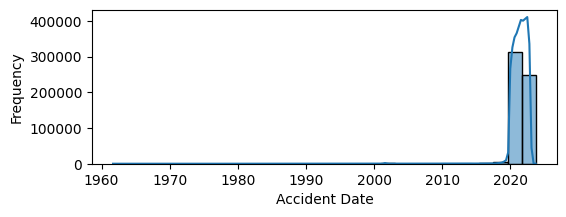

In [100]:
plot_hist(df_train, 'Accident Date')

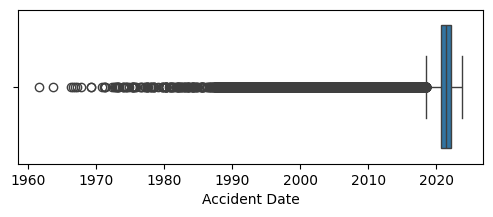

In [101]:
plot_box(df_train, 'Accident Date')

We can see by the histogram, that this variable is very assimetric probably due to having a big number of outliers as we can see in the boxplot. To get better visualisations we will omit this outliers in some visualisations

Now we will analyze the situation regarding the missing values:

In [102]:
print('The Accident Date variable has ' + str(df_train['Accident Date'].isna().mean()*100) + '% of missing values')
print('The Accident Date variable has ' + str(df_test['Accident Date'].isna().mean()*100) + '% of missing values')

The Accident Date variable has 3.898084320885098% of missing values
The Accident Date variable has 0.6299374959726787% of missing values


In [104]:
detect_outliers_in_column(df_train, 'Accident Date')['Accident Date'].max()

Timestamp('2018-07-21 00:00:00')

Let`s extract some adicional date-related columns

In [105]:
df_train['Accident Year'] = df_train['Accident Date'].dt.year
df_train['Accident Month'] = df_train['Accident Date'].dt.month
df_train['Accident DayOfWeek'] = df_train['Accident Date'].dt.dayofweek

This next bar plot show us the number of accidents by day of th week:

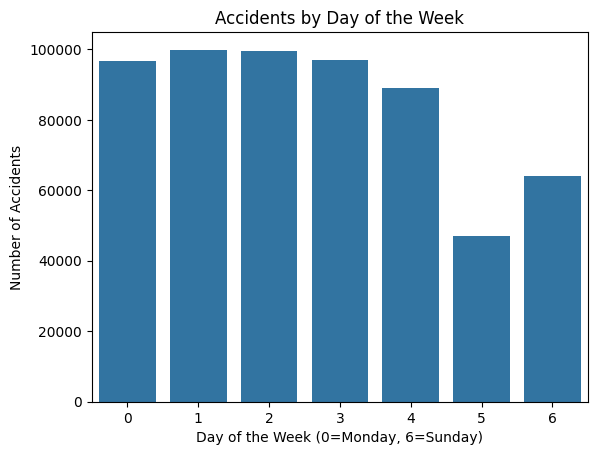

In [106]:
dayofweek_accidents = df_train['Accident DayOfWeek'].value_counts().sort_index()
sns.barplot(x=dayofweek_accidents.index, y=dayofweek_accidents.values)
plt.title("Accidents by Day of the Week")
plt.xlabel("Day of the Week (0=Monday, 6=Sunday)")
plt.ylabel("Number of Accidents")
plt.show()

This plot shows that workplace accidents occur more frequently during weekdays, likely because most people work Monday through Friday, resulting in fewer incidents over the weekend when fewer people are on-site

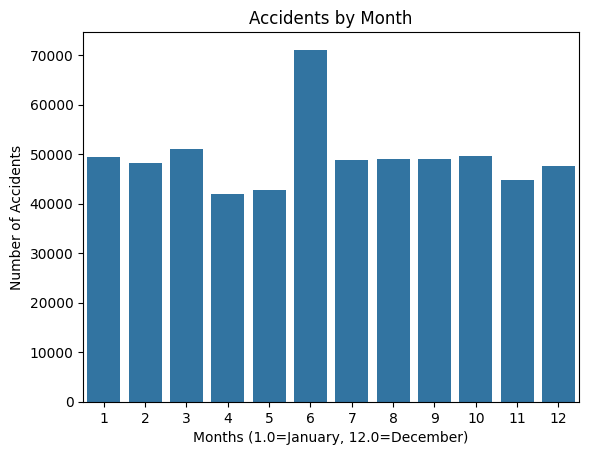

In [107]:
dayofweek_accidents = df_train['Accident Month'].value_counts().sort_index()
sns.barplot(x=dayofweek_accidents.index, y=dayofweek_accidents.values)
plt.title("Accidents by Month")
plt.xlabel("Months (1.0=January, 12.0=December)")
plt.ylabel("Number of Accidents")
plt.show()

From the graph, we notice a decrease in workplace accidents in April and May. What could explain this trend?

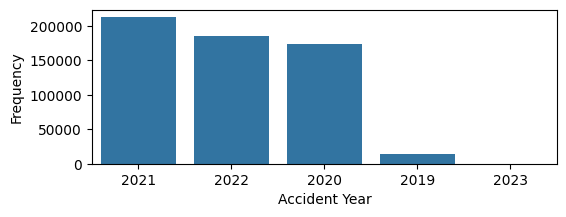

In [108]:
plot_bar(df_train[df_train['Accident Year']>2018], 'Accident Year')

### Age at injury variable

Let's examine the key statistics for this variable:

In [109]:
df_train['Age at Injury'].describe()

,Age at Injury
count,574026.000000
mean,42.114270
std,14.256432
min,0.000000
25%,31.000000
50%,42.000000
75%,54.000000
max,117.000000


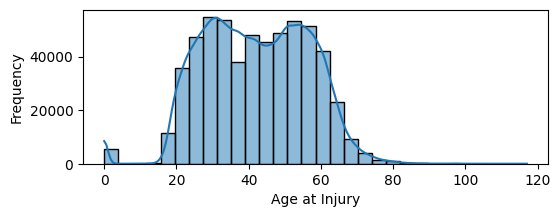

In [110]:
plot_hist(df_train, 'Age at Injury')

In [111]:
print(df_train[df_train['Age at Injury']==0]['Age at Injury'].count())
print(df_test[df_test['Age at Injury']==0]['Age at Injury'].count())

5464
3248


There is in this variable at the two dataframes null values, we will fill them with NAN values because they are probably due to some data coleting problem.

In [112]:
df_train['Age at Injury'] = df_train['Age at Injury'].replace(0, np.nan)
df_test['Age at Injury'] = df_test['Age at Injury'].replace(0, np.nan)

Another issue is the presence of incorrect values in this variable. Specifically, ages below 14 are invalid, as the minimum working age in the U.S. is 14 years. Additionally, ages exceeding 80 are also considered erroneous.

In [113]:
print(df_train[(df_train['Age at Injury'] < 14) | (df_train['Age at Injury'] > 80)]['Age at Injury'].count())
print(df_test[(df_test['Age at Injury'] < 14) | (df_test['Age at Injury'] > 80)]['Age at Injury'].count())

838
900


As there is a small number of rows with these problem, we will just eliminate them

In [114]:
df_train = df_train[(df_train['Age at Injury'] >= 14) & (df_train['Age at Injury'] <= 80)]
df_test = df_test[(df_test['Age at Injury'] >= 14) & (df_test['Age at Injury'] <= 80)]

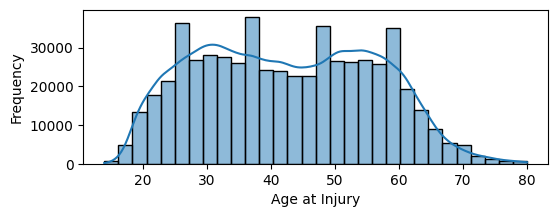

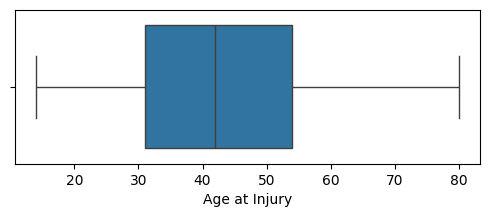

In [115]:
plot_hist(df_train, 'Age at Injury')
plot_box(df_train, 'Age at Injury')

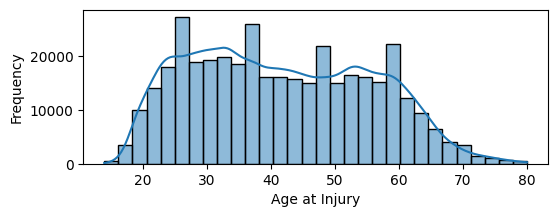

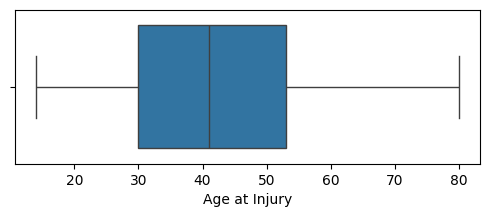

In [116]:
plot_hist(df_test, 'Age at Injury')
plot_box(df_test, 'Age at Injury')

### Assembly date variable

First, we need to ensure that this variable is in the correct date format.

In [129]:
df_train['Assembly Date'] = pd.to_datetime(df_train['Assembly Date'])

Let's examine the key statistics for this variable:

In [130]:
df_train['Assembly Date'].describe()

,Assembly Date
count,567724
mean,2021-07-20 06:54:45.861439744
min,2020-01-01 00:00:00
25%,2020-10-27 00:00:00
50%,2021-08-02 00:00:00
75%,2022-04-20 00:00:00
max,2022-12-31 00:00:00


In [133]:
print('The Assembly Date variable has ' + str(df_train['Assembly Date'].isna().mean()*100) + '% of missing values in the train data')
print('The Assembly Date variable has ' + str(df_test['Assembly Date'].isna().mean()*100) + '% of missing values in the test data')

The Assembly Date variable has 0.0% of missing values in the train data
The Assembly Date variable has 0.0% of missing values in the test data


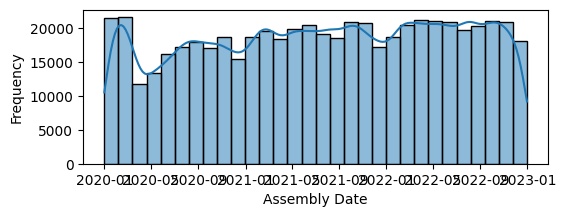

In [131]:
plot_hist(df_train, 'Assembly Date')

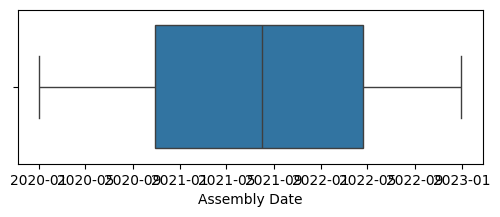

In [134]:
plot_box(df_train, 'Assembly Date')

From this table, we see that the first assembly date in this dataframe occurred on 2020-01-01 and the last one on 2022-12-31.

### C-2 Date variable

First, we need to ensure that this variable is in the correct date format.

In [144]:
df_train['C-2 Date'] = pd.to_datetime(df_train['C-2 Date'])
df_test['C-2 Date'] = pd.to_datetime(df_test['C-2 Date'])

Let's examine the key statistics for this variable:

In [145]:
df_train['C-2 Date'].describe()

,C-2 Date
count,555555
mean,2021-07-16 22:31:25.409725184
min,1996-01-12 00:00:00
25%,2020-11-06 00:00:00
50%,2021-08-09 00:00:00
75%,2022-04-26 00:00:00
max,2024-06-01 00:00:00


In [148]:
print('The C-2 Date variable has ' + str(df_train['C-2 Date'].isna().mean()*100) + '% of missing values in the train data')
print('The C-2 Date variable has ' + str(df_test['C-2 Date'].isna().mean()*100) + '% of missing values in the test data')

The C-2 Date variable has 2.1434711232923043% of missing values in the train data
The C-2 Date variable has 2.117620698908623% of missing values in the test data


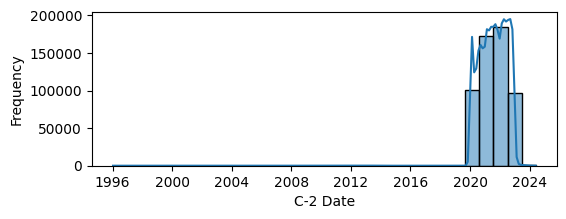

In [146]:
plot_hist(df_train, 'C-2 Date')

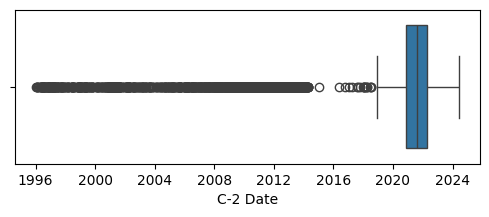

In [147]:
plot_box(df_train, 'C-2 Date')

### C-3 Date

First, we need to ensure that this variable is in the correct date format.

In [149]:
df_train['C-3 Date'] = pd.to_datetime(df_train['C-3 Date'])
df_test['C-3 Date'] = pd.to_datetime(df_test['C-3 Date'])

Let's examine the key statistics for this variable:

In [150]:
df_train['C-3 Date'].describe()

,C-3 Date
count,183294
mean,2021-07-28 10:41:46.059118592
min,2010-07-29 00:00:00
25%,2020-10-28 00:00:00
50%,2021-07-22 00:00:00
75%,2022-04-20 00:00:00
max,2024-05-31 00:00:00


In [151]:
print('The C-3 Date variable has ' + str(df_train['C-3 Date'].isna().mean()*100) + '% of missing values in the train data')
print('The C-3 Date variable has ' + str(df_test['C-3 Date'].isna().mean()*100) + '% of missing values in the test data')

The C-3 Date variable has 67.71424142717237% of missing values in the train data
The C-3 Date variable has 78.44601864902677% of missing values in the test data


This variable is highly composed of missing values, so we will probably exclude her

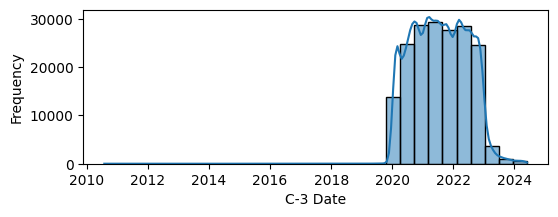

In [152]:
plot_hist(df_train, 'C-3 Date')

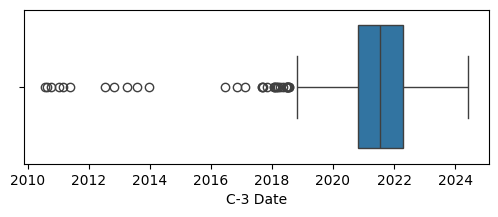

In [153]:
plot_box(df_train, 'C-3 Date')

### First Hearing Date variable

First, we need to ensure that this variable is in the correct date format.

In [154]:
df_train['First Hearing Date'] = pd.to_datetime(df_train['First Hearing Date'])
df_test['First Hearing Date'] = pd.to_datetime(df_test['First Hearing Date'])

Let's examine the key statistics for this variable:

In [155]:
df_train['First Hearing Date'].describe()

,First Hearing Date
count,148951
mean,2022-03-20 05:29:29.486609664
min,2020-01-30 00:00:00
25%,2021-06-02 00:00:00
50%,2022-03-10 00:00:00
75%,2023-01-11 00:00:00
max,2024-06-07 00:00:00


In [156]:
print('The First Hearing Date variable has ' + str(df_train['First Hearing Date'].isna().mean()*100) + '% of missing values in the train data')
print('The First Hearing Date has ' + str(df_test['First Hearing Date'].isna().mean()*100) + '% of missing values in the test data')

The First Hearing Date variable has 73.76348366459759% of missing values in the train data
The First Hearing Date has 89.03047466697235% of missing values in the test data


This variable is highly composed of missing values, so we will probably exclude her

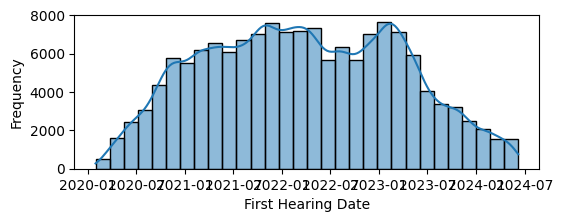

In [157]:
plot_hist(df_train, 'First Hearing Date')

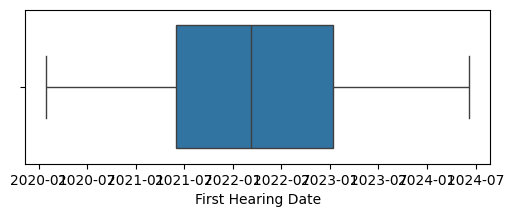

In [158]:
plot_box(df_train, 'First Hearing Date')

In [117]:
# For each column
    # Descriptive stats
    # Visualization (Bar, hist, boxplot, .., whatever makes sense)
        # Use above helper function
    # Problems (missing values, invalid values etc.)
        # show examples etc.
    # how to deal with the problems
        # remove rows? replace with null? what happens to null values (replace with median, knN, mode etc)?
        # analyse and find solution with train -> apply solution to train and test

In [118]:
# Empty columns: WCB Decision (in test), OIICS Nature of Injury Description, Agreement Reached
    # Ignore those

In [119]:
# Daniel:
"""
 0   Accident Date                       570337 non-null  datetime64[ns]
 1   Age at Injury                       574026 non-null  float64
 3   Assembly Date                       593471 non-null  datetime64[ns]
 6   Birth Year                          544948 non-null  float64
 7   C-2 Date                            559466 non-null  datetime64[ns]
 8   C-3 Date                            187245 non-null  datetime64[ns]
 16  First Hearing Date                  150798 non-null  datetime64[ns]
 2   Alternative Dispute Resolution      574026 non-null  object
 4   Attorney/Representative             574026 non-null  object
 10  Carrier Type                        574026 non-null  object
 13  County of Injury                    574026 non-null  object
 """

'\n 0   Accident Date                       570337 non-null  datetime64[ns]\n 1   Age at Injury                       574026 non-null  float64    \n 3   Assembly Date                       593471 non-null  datetime64[ns]\n 6   Birth Year                          544948 non-null  float64    \n 7   C-2 Date                            559466 non-null  datetime64[ns] \n 8   C-3 Date                            187245 non-null  datetime64[ns]\n 16  First Hearing Date                  150798 non-null  datetime64[ns]\n 2   Alternative Dispute Resolution      574026 non-null  object    \n 4   Attorney/Representative             574026 non-null  object       \n 10  Carrier Type                        574026 non-null  object        \n 13  County of Injury                    574026 non-null  object         \n '

In [120]:
# Louis:
"""
 19  Industry Code                       564068 non-null  float64
 20  Industry Code Description           564068 non-null  object
 21  Medical Fee Region                  574026 non-null  object
 23  WCIO Cause of Injury Code           558386 non-null  float64
 24  WCIO Cause of Injury Description    558386 non-null  object
 25  WCIO Nature of Injury Code          558369 non-null  float64
 26  WCIO Nature of Injury Description   558369 non-null  object
 27  WCIO Part Of Body Code              556944 non-null  float64
 28  WCIO Part Of Body Description       556944 non-null  object
 29  Zip Code                            545389 non-null  object
 12  Claim Injury Type                   574026 non-null  object
 17  Gender                              574026 non-null  object
"""

'\n 19  Industry Code                       564068 non-null  float64       \n 20  Industry Code Description           564068 non-null  object        \n 21  Medical Fee Region                  574026 non-null  object     \n 23  WCIO Cause of Injury Code           558386 non-null  float64       \n 24  WCIO Cause of Injury Description    558386 non-null  object        \n 25  WCIO Nature of Injury Code          558369 non-null  float64       \n 26  WCIO Nature of Injury Description   558369 non-null  object        \n 27  WCIO Part Of Body Code              556944 non-null  float64       \n 28  WCIO Part Of Body Description       556944 non-null  object        \n 29  Zip Code                            545389 non-null  object \n 12  Claim Injury Type                   574026 non-null  object\n 17  Gender                              574026 non-null  object        \n'

In [121]:
# Rita:
"""
 5   Average Weekly Wage                 545375 non-null  float64
 9   Carrier Name                        574026 non-null  object
 11  Claim Identifier                    593471 non-null  int64
 14  COVID-19 Indicator                  574026 non-null  object
 15  District Name                       574026 non-null  object
 18  IME-4 Count                         132803 non-null  float64
 22  Number of Dependents                574026 non-null  float64
"""

'\n 5   Average Weekly Wage                 545375 non-null  float64       \n 9   Carrier Name                        574026 non-null  object        \n 11  Claim Identifier                    593471 non-null  int64         \n 14  COVID-19 Indicator                  574026 non-null  object        \n 15  District Name                       574026 non-null  object        \n 18  IME-4 Count                         132803 non-null  float64       \n 22  Number of Dependents                574026 non-null  float64       \n'

## Step 3: Cross-Feature analysis

In [122]:
# cross-feature inconsistencies
    # all dates have to be after incident date
    # if covid code -> covid has to be true
    # code vs description (just check, we will ignore the descriptions later)
    # How to deal with inconsistencies
# cross-feature visualisations
    # Write down Visualisation insights

# Re-Run of Exploratory Analysis